In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./data/230907_basic_table_for_analysis_cleaned.csv", index_col=0, low_memory=False)

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 46 columns):
 #   Column        Dtype  
---  ------        -----  
 0   num_veh       object 
 1   place         float64
 2   catu          int64  
 3   grav          int64  
 4   sexe          int64  
 5   an_nais       float64
 6   trajet        float64
 7   locp          float64
 8   actp          object 
 9   etatp         float64
 10  an            int64  
 11  mois          int64  
 12  jour          int64  
 13  hrmn          object 
 14  lum           int64  
 15  agg           int64  
 16  int           int64  
 17  atm           float64
 18  col           float64
 19  adr           object 
 20  lat           float64
 21  long          float64
 22  dep           int64  
 23  metropolitan  float64
 24  catr          float64
 25  circ          float64
 26  nbv           float64
 27  vosp          float64
 28  prof          float64
 29  plan          float64
 30  su

In [4]:
df['hrmn']

Num_Acc
201900000001    01:30
201900000001    01:30
201900000001    01:30
201900000002    02:50
201900000003    15:15
                ...  
201800057781     2150
201800057782     1945
201800057782     1945
201800057783     1425
201800057783     1425
Name: hrmn, Length: 2509596, dtype: object

In [5]:
# cleanning variables that might not be used in the model
df['date']= pd.to_datetime(df.date,format='%Y-%m-%d')
df['year'] = df['date'].dt.year.astype(int)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['actp'] = le.fit_transform(df['actp'].astype(str))
df['hrmn'] = le.fit_transform(df['hrmn'].astype(str))

In [6]:
df_M = df[df['metropolitan'] == 1]
df_M.head(3)

,num_veh,place,catu,grav,sexe,an_nais,trajet,locp,actp,etatp,...,obsm,choc,manv,date,is_holiday,holiday,secu_used,secu_avail,fatal,year
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,B01,2.0,2,4,2,2002.0,0.0,-1.0,0,-1.0,...,2.0,5.0,23.0,2019-11-30,False,NaN,3,1,0,2019
201900000001,B01,1.0,1,4,2,1993.0,5.0,-1.0,0,-1.0,...,2.0,5.0,23.0,2019-11-30,False,NaN,3,1,0,2019
201900000001,A01,1.0,1,1,1,1959.0,0.0,-1.0,0,-1.0,...,0.0,3.0,11.0,2019-11-30,False,NaN,3,1,0,2019


In [7]:
#cleanning variables that might not be used in the model
df_rf = df_M.drop(['num_veh','adr','date','holiday','lat', 'long','grav'], axis=1) # grav removed because is similat to target 

In [8]:
#split the data for modeling
# 2005 to 2019 for trainning  and 2020 to 2021 to test

# Filter data for the training period (2005-2018)
train_data = df_rf[(df_rf['an'] >= 2005) & (df_rf['an'] <= 2019)]

# Filter data for the testing period (2019-2021)
test_data = df_rf[(df_rf['an'] >= 2020) & (df_rf['an'] <= 2021)]
 #Separate features and target variable
X_train = train_data.drop('fatal', axis=1)  # Features for training
y_train = train_data['fatal']  # Target variable for training

# Separate features and target variable
X_test = test_data.drop('fatal', axis=1)  # Features for training
y_test = test_data['fatal']  # Target variable for training


In [9]:
df_rf['fatal'].value_counts(normalize=True)

0    0.973626
1    0.026374
Name: fatal, dtype: float64

In [10]:
# import classifier
from sklearn.ensemble import RandomForestClassifier

# import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import evaluation tools
from sklearn.model_selection import KFold, cross_val_score

In [11]:
 #instantiate RandomForestClassifier with entropy and class_weight
forest_1 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1, class_weight='balanced')

# train
forest_1.fit(X_train, y_train)

# predict
y_test_preds  = forest_1.predict(X_test)

# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and class_weight Parameter: \n', report)

Classification Report Random Forest - with Entropy and class_weight Parameter: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    215726
           1       0.66      0.01      0.02      5539

    accuracy                           0.98    221265
   macro avg       0.82      0.50      0.50    221265
weighted avg       0.97      0.98      0.96    221265



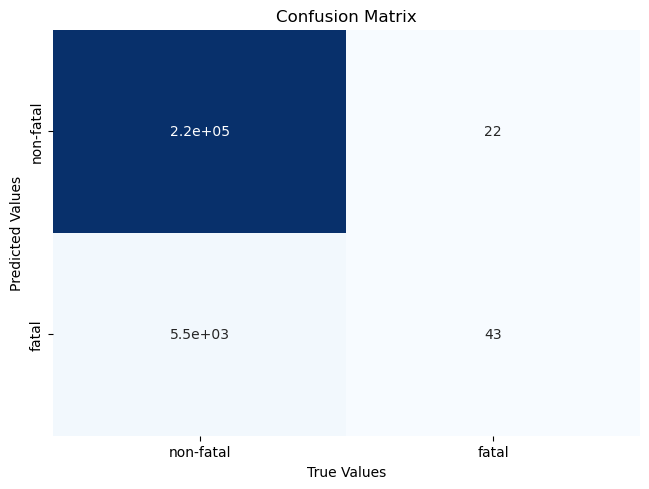

In [13]:
# create confusion matrix# create confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = df_rf.fatal.values
dataframe = pd.DataFrame(matrix, index=['non-fatal', 'fatal'], 
                         columns=['non-fatal', 'fatal'])

# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()



In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming you have already calculated the confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# Create a DataFrame from the confusion matrix
class_names = df_rf.fatal.values
dataframe = pd.DataFrame(matrix, index=['non-fatal', 'fatal'], 
                         columns=['non-fatal', 'fatal'])

# Display the confusion matrix as text
print("Confusion Matrix:")
print(dataframe)

Confusion Matrix:
           non-fatal  fatal
non-fatal     215704     22
fatal           5496     43


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier instance (replace with your hyperparameters)
forest_1 = RandomForestClassifier(random_state=42)

# Perform cross-validation with F1 score
f1_scores = cross_val_score(forest_1, X_train, y_train, scoring='f1_macro', n_jobs=2)

# Print the F1 scores for each fold
print("F1 Scores:", f1_scores)




F1 Scores: [0.50540933 0.51192099 0.51724217 0.50856543 0.50923718]


In [17]:
# Instantiate RandomForestClassifier with entropy and class_weight
forest_1 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1, class_weight='balanced_subsample')

# Train the model
forest_1.fit(X_train, y_train)

# Predict
y_test_preds = forest_1.predict(X_test)

# Evaluate using classification report
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and class_weight Parameter:\n', report)


Classification Report Random Forest - with Entropy and class_weight Parameter:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    215726
           1       0.64      0.01      0.01      5539

    accuracy                           0.98    221265
   macro avg       0.81      0.50      0.50    221265
weighted avg       0.97      0.98      0.96    221265



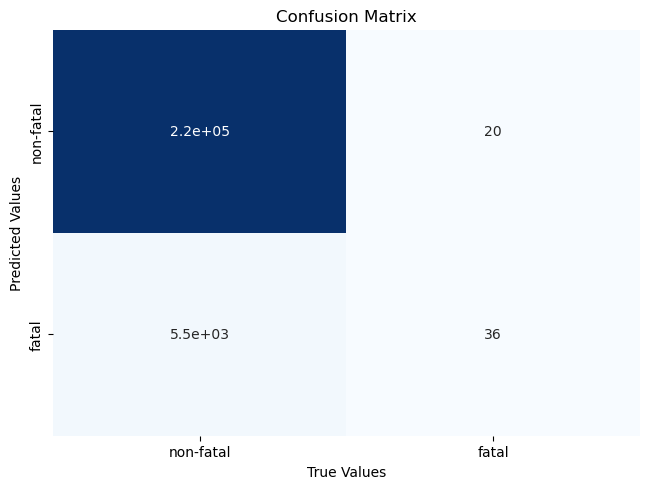

In [18]:
# create confusion matrix# create confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = df_rf.fatal.values
dataframe = pd.DataFrame(matrix, index=['non-fatal', 'fatal'], 
                         columns=['non-fatal', 'fatal'])

# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()